In [3]:

import sys
sys.path.append('../../../')
sys.path.append('../../')
sys.path.append('../')

from multiprocessing import Process
from omegaconf import OmegaConf
from core.run_lib import *

root_dir = '../../../'
conf_dir = f'{root_dir}configs/calib-exp/'
post_hoc_dir = f'{root_dir}configs/calib-exp/post-hoc/'

base_conf_file = '{}/cifar10_sn_base_conf_torch.yaml'.format(conf_dir)
root_pfx = 'cifar10_sn_post_hoc_calib-exp-runs'
root_pfx = f'{root_dir}/outputs/{root_pfx}'

top_lbl_hb_calib_base_conf = OmegaConf.load(f'{post_hoc_dir}/top_label_hist_bin_base_conf.yaml')
platt_scaling_calib_base_conf = OmegaConf.load(f'{post_hoc_dir}/platt_scaling_base_conf.yaml')


base_params = {
      'C_1': 0, 
      'max_num_train_pts': 500, 
      'max_num_val_pts':1000,
      'eps':0.01,
      'method':'active_labeling',
      'C':2,
      'seed_frac':0.2,
      'query_batch_frac':0.05}

lst_outs = get_all_outs_for_exp(root_pfx)

['../../..//outputs/cifar10_sn_post_hoc_calib-exp-runs/C__2/C_1__0/calib_conf__None/eps__0.01/max_num_train_pts__500/max_num_val_pts__1000/method__active_labeling/query_batch_frac__0.05/seed__0/seed_frac__0.2/active_labeling.pkl']


In [2]:
print(len(lst_outs))
print(lst_outs[0].keys())

0


IndexError: list index out of range

In [3]:
lst_top_lbl_hb_calib_confs = [top_lbl_hb_calib_base_conf]

lst_calib_conf = lst_top_lbl_hb_calib_confs #+ lst_platt_calib_confs

# Signature that identifies no calibration
param_f = copy.deepcopy(base_params )
param_f['calib_conf'] = 'None'
out_f_nc =  filter_outputs(lst_outs,param_f) # only returns 1 config
df_nc =  pd.DataFrame(out_f_nc)

# Signature that identifies a histogram binning top label calibration 
param_f = copy.deepcopy(base_params )
param_f['calib_conf_name'] = 'histogram_binning_top_label'
out_f_thb =  filter_outputs(lst_outs,param_f) # only returns 1 config
df_thb =  pd.DataFrame(out_f_thb)

In [4]:
display(df_nc )

,sel_auto_labeled_acc,sel_coverage,all_auto_labeled_acc,all_coverage,avg_ece_on_val,lst_epoch_out,C,C_1,calib_conf,eps,max_num_train_pts,max_num_val_pts,method,query_batch_frac,seed,seed_frac
0,0.983417,0.924667,0.983417,0.924667,0.120732,"[{'seed_train_pts': [6985, 6298, 166, 159, 856...",2,0,None,0.01,500,1000,active_labeling,0.05,0,0.2


In [5]:
display(df_thb)

,sel_auto_labeled_acc,sel_coverage,all_auto_labeled_acc,all_coverage,avg_ece_on_val,lst_epoch_out,C,C_1,calib_conf_name,calib_conf_points_per_bin,eps,max_num_train_pts,max_num_val_pts,method,query_batch_frac,seed,seed_frac
0,0.993671,0.921667,0.993671,0.921667,0.019984,"[{'seed_train_pts': [6985, 6298, 166, 159, 856...",2,0,histogram_binning_top_label,50,0.01,500,1000,active_labeling,0.05,0,0.2


In [6]:
print(1-df_nc['sel_auto_labeled_acc'].mean() ,df_nc['sel_coverage'].mean() )
print(df_nc['sel_auto_labeled_acc'].std() ,df_nc['sel_coverage'].std() )

0.016582552271088735 0.9246666666666666
nan nan


In [7]:
print(1-df_thb['sel_auto_labeled_acc'].mean() ,df_thb['sel_coverage'].mean() )
print(df_thb['sel_auto_labeled_acc'].std() ,df_thb['sel_coverage'].std() )

0.006329113924050667 0.9216666666666666
nan nan


In [8]:

# Signature that identifies a platt scaling calibration
param_f = copy.deepcopy(base_params )
param_f['calib_conf_name'] = 'platt_scaling'
out_ps =  filter_outputs(lst_outs,param_f)
df_ps =  pd.DataFrame(out_ps)

In [9]:
display(df_ps)

,sel_auto_labeled_acc,sel_coverage,all_auto_labeled_acc,all_coverage,avg_ece_on_val,lst_epoch_out,C,C_1,calib_conf_name,calib_conf_training_conf,eps,max_num_train_pts,max_num_val_pts,method,query_batch_frac,seed,seed_frac
0,0.983932,0.923167,0.983932,0.923167,0.208721,"[{'seed_train_pts': [6985, 6298, 166, 159, 856...",2,0,platt_scaling,"{'optimizer': 'adam', 'learning_rate': 0.5, 'b...",0.01,500,1000,active_labeling,0.05,0,0.2


In [10]:
def plot_calibration_metrics(configs: list) -> None: 
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    for j in range(len(configs)) :
        lst_epoch_out = configs[j]['lst_epoch_out']
        # Iterate through all epochs
        auto_labeled_acc = np.array([])
        coverage_1 = np.array([])
        ece = np.array([])
        for i in range(len(lst_epoch_out)):
            if 'ECE_on_val' not in lst_epoch_out[i].keys():
                print(f'Config: {j} - ECE_on_val not found at epoch {i} of {len(lst_epoch_out)-1}')
                continue
            # Collect all autolabeling accuracies
            auto_labeled_acc = np.append(auto_labeled_acc, lst_epoch_out[i]['cur_counts']['auto_labeled_acc'])
            
            # Collect all coverages
            coverage_1 = np.append(coverage_1, lst_epoch_out[i]['cur_counts']['coverage_1'])

            # Collect all ECE values
            ece = np.append(ece, lst_epoch_out[i]['ECE_on_val'])

        # Plotting
        auto_labeled_err_func = lambda x: 1.0 - x if x is not None else None 
        try:
            clb_m = configs[j]['calib_conf'] # no calibration signature
        except:
            clb_m = configs[j]['calib_conf_name'] # calibration signature
        ax[0].plot((list(map(auto_labeled_err_func, auto_labeled_acc))), label=f'config {j}: {clb_m}'); ax[0].set_title(f'Auto-labeled error'); ax[0].set_xlabel('Epoch(s)')
        ax[1].plot(coverage_1, label=f'config {j}: {clb_m}'); ax[1].set_title(f'Coverage'); ax[1].set_xlabel('Epoch(s)')
        ax[2].plot(ece, label=f'config {j}: {clb_m}'); ax[2].set_title(f'ECE'); ax[2].set_xlabel('Epoch(s)')
    ax[0].legend(); ax[1].legend(); ax[2].legend()

Config: 0 - ECE_on_val not found at epoch 7 of 7
Config: 1 - ECE_on_val not found at epoch 15 of 15
Config: 2 - ECE_on_val not found at epoch 9 of 9
Config: 3 - ECE_on_val not found at epoch 15 of 15
Config: 4 - ECE_on_val not found at epoch 9 of 9
Config: 5 - ECE_on_val not found at epoch 15 of 15


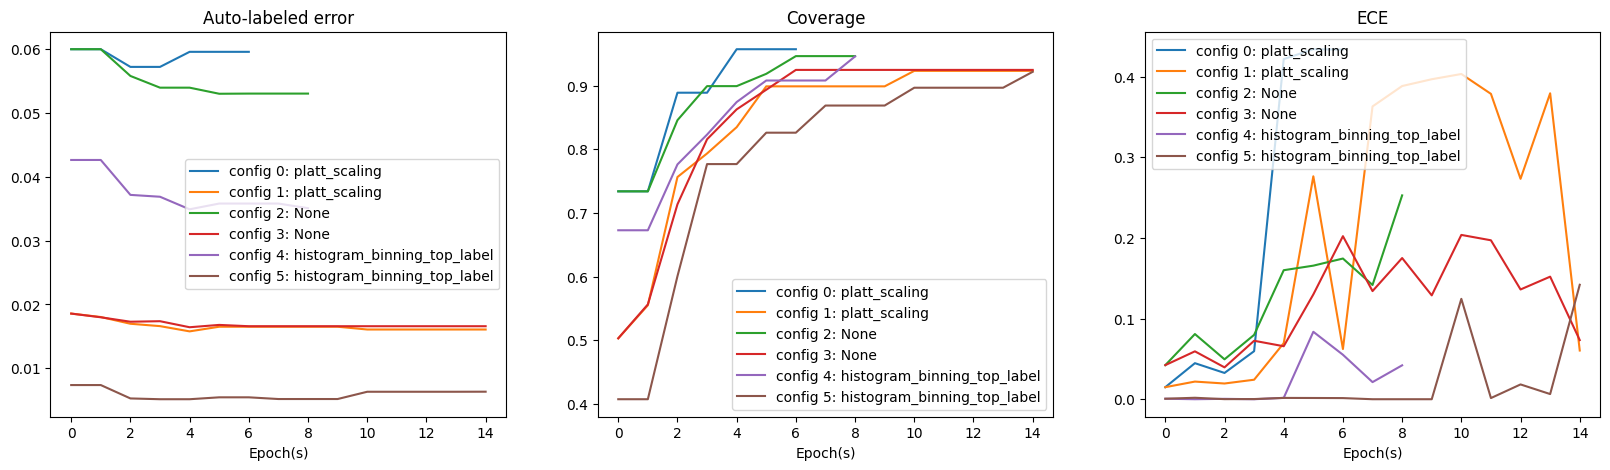

In [11]:
plot_calibration_metrics(lst_outs)